http://preview.d2l.ai/d2l-en/master/chapter_attention-mechanisms/transformer.html

In [2]:
from d2l import mxnet as d2l
import math
from mxnet import autograd, np, npx
from mxnet.gluon import nn
npx.set_np()

In [4]:
#@save
class MultiHeadAttention(nn.Block):
    def __init__(self, num_hiddens, num_heads, dropout, use_bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.Dense(num_hiddens, use_bias=use_bias, flatten=False)
        self.W_k = nn.Dense(num_hiddens, use_bias=use_bias, flatten=False)
        self.W_v = nn.Dense(num_hiddens, use_bias=use_bias, flatten=False)
        self.W_o = nn.Dense(num_hiddens, use_bias=use_bias, flatten=False)

    def forward(self, query, key, value, valid_len):
        # For self-attention, `query`, `key`, and `value` shape:
        # (`batch_size`, `seq_len`, `dim`), where `seq_len` is the length of
        # input sequence. `valid_len` shape is either (`batch_size`, ) or
        # (`batch_size`, `seq_len`).

        # Project and transpose `query`, `key`, and `value` from
        # (`batch_size`, `seq_len`, `num_hiddens`) to
        # (`batch_size` * `num_heads`, `seq_len`, `num_hiddens` / `num_heads`)
        query = transpose_qkv(self.W_q(query), self.num_heads)
        key = transpose_qkv(self.W_k(key), self.num_heads)
        value = transpose_qkv(self.W_v(value), self.num_heads)

        if valid_len is not None:
            # Copy `valid_len` by `num_heads` times
            if valid_len.ndim == 1:
                valid_len = np.tile(valid_len, self.num_heads)
            else:
                valid_len = np.tile(valid_len, (self.num_heads, 1))

        # For self-attention, `output` shape:
        # (`batch_size` * `num_heads`, `seq_len`, `num_hiddens` / `num_heads`)
        output = self.attention(query, key, value, valid_len)

        # `output_concat` shape: (`batch_size`, `seq_len`, `num_hiddens`)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

In [6]:
#@save
def transpose_qkv(X, num_heads):
    # Input `X` shape: (`batch_size`, `seq_len`, `num_hiddens`).
    # Output `X` shape:
    # (`batch_size`, `seq_len`, `num_heads`, `num_hiddens` / `num_heads`)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)

    # `X` shape:
    # (`batch_size`, `num_heads`, `seq_len`, `num_hiddens` / `num_heads`)
    X = X.transpose(0, 2, 1, 3)

    # `output` shape:
    # (`batch_size` * `num_heads`, `seq_len`, `num_hiddens` / `num_heads`)
    output = X.reshape(-1, X.shape[2], X.shape[3])
    return output


#@save
def transpose_output(X, num_heads):
    # A reversed version of `transpose_qkv`
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.transpose(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

In [8]:
cell = MultiHeadAttention(90, 9, 0.5)
cell.initialize()
X = np.ones((2, 4, 5))
valid_len = np.array([2, 3])
cell(X, X, X, valid_len).shape

(2, 4, 90)

In [10]:
#@save
class PositionWiseFFN(nn.Block):
    def __init__(self, ffn_num_hiddens, pw_num_outputs, **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Dense(ffn_num_hiddens, flatten=False,
                               activation='relu')
        self.dense2 = nn.Dense(pw_num_outputs, flatten=False)

    def forward(self, X):
        return self.dense2(self.dense1(X))

In [12]:
ffn = PositionWiseFFN(4, 8)
ffn.initialize()
ffn(np.ones((2, 3, 4)))[0]

array([[-0.00108205,  0.00303298, -0.00025003,  0.00328319, -0.00030516,
         0.00294479,  0.00138365, -0.00423853],
       [-0.00108205,  0.00303298, -0.00025003,  0.00328319, -0.00030516,
         0.00294479,  0.00138365, -0.00423853],
       [-0.00108205,  0.00303298, -0.00025003,  0.00328319, -0.00030516,
         0.00294479,  0.00138365, -0.00423853]])

In [14]:
layer = nn.LayerNorm()
layer.initialize()
batch = nn.BatchNorm()
batch.initialize()
X = np.array([[1, 2], [2, 3]])
# Compute mean and variance from `X` in the training mode
with autograd.record():
    print('layer norm:', layer(X), '\nbatch norm:', batch(X))

layer norm: [[-0.99998  0.99998]
 [-0.99998  0.99998]] 
batch norm: [[-0.99998 -0.99998]
 [ 0.99998  0.99998]]


In [16]:
#@save
class AddNorm(nn.Block):
    def __init__(self, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm()

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [18]:
add_norm = AddNorm(0.5)
add_norm.initialize()
add_norm(np.ones((2, 3, 4)), np.ones((2, 3, 4))).shape

(2, 3, 4)

In [20]:
#@save
class PositionalEncoding(nn.Block):
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough `P`
        self.P = np.zeros((1, max_len, num_hiddens))
        X = np.arange(0, max_len).reshape(-1, 1) / np.power(
            10000, np.arange(0, num_hiddens, 2) / num_hiddens)
        self.P[:, :, 0::2] = np.sin(X)
        self.P[:, :, 1::2] = np.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].as_in_ctx(X.ctx)
        return self.dropout(X)

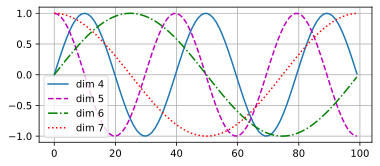

In [22]:
pe = PositionalEncoding(20, 0)
pe.initialize()
Y = pe(np.zeros((1, 100, 20)))
d2l.plot(np.arange(100), Y[0, :, 4:8].T, figsize=(6, 2.5),
         legend=["dim %d" % p for p in [4, 5, 6, 7]])

In [24]:
#@save
class EncoderBlock(nn.Block):
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout,
                 use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = MultiHeadAttention(num_hiddens, num_heads, dropout,
                                            use_bias)
        self.addnorm1 = AddNorm(dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(dropout)

    def forward(self, X, valid_len):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_len))
        return self.addnorm2(Y, self.ffn(Y))

In [26]:
X = np.ones((2, 100, 24))
encoder_blk = EncoderBlock(24, 48, 8, 0.5)
encoder_blk.initialize()
encoder_blk(X, valid_len).shape

(2, 100, 24)

In [28]:
#@save
class TransformerEncoder(d2l.Encoder):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for _ in range(num_layers):
            self.blks.add(
                EncoderBlock(num_hiddens, ffn_num_hiddens, num_heads, dropout,
                             use_bias))

    def forward(self, X, valid_len, *args):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        for blk in self.blks:
            X = blk(X, valid_len)
        return X

In [30]:
encoder = TransformerEncoder(200, 24, 48, 8, 2, 0.5)
encoder.initialize()
encoder(np.ones((2, 100)), valid_len).shape

(2, 100, 24)

In [32]:
class DecoderBlock(nn.Block):
    # `i` means it is the i-th block in the decoder
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = MultiHeadAttention(num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(dropout)
        self.attention2 = MultiHeadAttention(num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_len = state[0], state[1]
        # `state[2][i]` contains the past queries for this block
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = np.concatenate((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if autograd.is_training():
            batch_size, seq_len, _ = X.shape
            # Shape: (batch_size, seq_len), the values in the j-th column
            # are j+1
            valid_len = np.tile(np.arange(1, seq_len + 1, ctx=X.ctx),
                                (batch_size, 1))
        else:
            valid_len = None

        X2 = self.attention1(X, key_values, key_values, valid_len)
        Y = self.addnorm1(X, X2)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_len)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [34]:
decoder_blk = DecoderBlock(24, 48, 8, 0.5, 0)
decoder_blk.initialize()
X = np.ones((2, 100, 24))
state = [encoder_blk(X, valid_len), valid_len, [None]]
decoder_blk(X, state)[0].shape

(2, 100, 24)

In [36]:
class TransformerDecoder(d2l.Decoder):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add(
                DecoderBlock(num_hiddens, ffn_num_hiddens, num_heads,
                             dropout, i))
        self.dense = nn.Dense(vocab_size, flatten=False)

    def init_state(self, enc_outputs, env_valid_len, *args):
        return [enc_outputs, env_valid_len, [None]*self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        for blk in self.blks:
            X, state = blk(X, state)
        return self.dense(X), state

loss 0.032, 2133.0 tokens/sec on cpu(0)


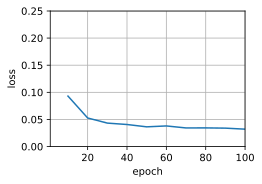

In [38]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.0, 64, 10
lr, num_epochs, device = 0.005, 100, d2l.try_gpu()
ffn_num_hiddens, num_heads = 64, 4

src_vocab, tgt_vocab, train_iter = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab), num_hiddens, ffn_num_hiddens, num_heads, num_layers,
    dropout)
decoder = TransformerDecoder(
    len(src_vocab), num_hiddens, ffn_num_hiddens, num_heads, num_layers,
    dropout)
model = d2l.EncoderDecoder(encoder, decoder)
d2l.train_s2s_ch9(model, train_iter, lr, num_epochs, device)

In [40]:
for sentence in ['Go .', 'Wow !', "I'm OK .", 'I won !']:
    print(sentence + ' => ' + d2l.predict_s2s_ch9(
        model, sentence, src_vocab, tgt_vocab, num_steps, device))

Go . => va !
Wow ! => <unk> !
I'm OK . => ça va .
I won ! => je l'ai emporté !
